In [6]:
import pandas as pd

# Load the CSV file
file_path = '/Users/gracekight/Desktop/customer_booking.csv'

data = pd.read_csv(file_path, encoding='latin1')

# Create a copy of the filtered data to ensure we are working with a fresh, independent DataFrame
filtered_data = data[
    (data['sales_channel'] == 'Internet') & (data['trip_type'] == 'RoundTrip')
].copy()

# Select the necessary columns and rename them in one step (no inplace)
result_df = filtered_data[['num_passengers', 'purchase_lead', 'booking_complete']]

# Rename columns by directly reassigning the DataFrame
result_df = result_df.rename(columns={
    'num_passengers': 'size',
    'purchase_lead': 'lead_time',
    'booking_complete': 'booking'
})

# Set the index to start at 1
result_df.index = range(1, len(result_df) + 1)

# Check the resulting DataFrame
print(result_df.head())



   size  lead_time  booking
1     2        262        0
2     1        112        0
3     2        243        0
4     1         96        0
5     2         68        0


In [7]:
# Check the column names to verify exact names
print(result_df.columns)


Index(['size', 'lead_time', 'booking'], dtype='object')


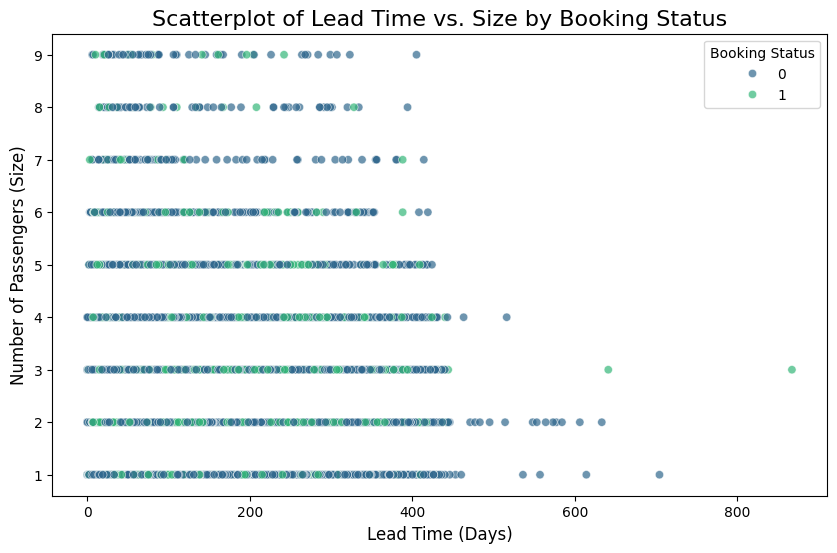

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=result_df,
    x='lead_time',  # Independent variable
    y='size',       # Independent variable
    hue='booking',  # Dependent variable (classification target)
    palette='viridis',  # Color palette for classes
    alpha=0.7       # Transparency for overlapping points
)

# Add labels and title
plt.title('Scatterplot of Lead Time vs. Size by Booking Status', fontsize=16)
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Number of Passengers (Size)', fontsize=12)
plt.legend(title='Booking Status', loc='upper right')

# Show the plot
plt.show()


****ANALYSIS OF SCATTERPLOT****

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [10]:
# Step 1: Prepare your data
# Example: Create a synthetic classification dataset
# Replace this with your actual dataset if you have it (e.g., `result_df` or another DataFrame)
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# For example, if you already have a DataFrame `result_df`:
# X = result_df[['lead_time', 'size']]  # Features
# y = result_df['booking']  # Target

# Step 2: Initialize models with parameters
logreg = LogisticRegression(max_iter=100, random_state=42)
dtree = DecisionTreeClassifier(max_depth=10, random_state=42)
gnb = GaussianNB()

# Step 3: Perform cross-validation for each classifier

# Logistic Regression: Cross-validation score
logreg_cv = cross_val_score(logreg, X, y, cv=10)
print(f'Logistic Regression CV Mean Accuracy: {np.mean(logreg_cv):.4f}')

# Decision Tree Classifier: Cross-validation score
dtree_cv = cross_val_score(dtree, X, y, cv=10)
print(f'Decision Tree CV Mean Accuracy: {np.mean(dtree_cv):.4f}')

# Gaussian Naive Bayes: Cross-validation score
gnb_cv = cross_val_score(gnb, X, y, cv=10)
print(f'Gaussian Naive Bayes CV Mean Accuracy: {np.mean(gnb_cv):.4f}')


Logistic Regression CV Mean Accuracy: 0.8570
Decision Tree CV Mean Accuracy: 0.8840
Gaussian Naive Bayes CV Mean Accuracy: 0.8400


*****BEST METHOD ANALYSIS:*****
Decision Tree has highest mean accuracy 